In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import requests
from bs4 import BeautifulSoup
from io import StringIO
from io import BytesIO
import zipfile
from zipfile import ZipFile
from urllib.request import urlopen

# Maps

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

1.	Please download and import all of FY16 Medicare Advantage Penetration data from the following website (https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/MA-State-County-Penetration.html) and conduct the following task in your preferred language (i.e., Stata, SAS, or R). Please think creatively about importing the 12 files. What if we asked you to read in 5 years’ worth of data instead of just a year?

In [2]:
# Download the html file from CMS file. The links do not have a systematic pattern. 
# It does not allow to do a loop. I initially did an automation to get only FY2016 but it was time-consuming. 
# Instead I downloaded the html files, which have all the links, to save in a csv file. It would be easier to read only FY2016 
# or more years from a csv file.


dfs = []
fnames = ['/Users/mehme/Downloads/MA State_County Penetration _ CMS p1.html',
          '/Users/mehme/Downloads/MA State_County Penetration _ CMS p2.html']
for fname in fnames:
    with open(fname) as fp:
        df = pd.read_html(fname)[0]
        table = BeautifulSoup(fp, 'html.parser').find('table')
        df['details_page'] = [link.get('href') for link in table.find_all('a')][2:]
        dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

def get_href(url):
    selector = '#block-cms-drupal-global-content > div > div > div > div.field.field--name-field-downloads.field--type-entity-reference.field--label-above > ul > li > div > a'
    soup = BeautifulSoup(requests.get(url).content)
    href = soup.select(selector)[0]['href']
    return href

df['href'] = df['details_page'].map(get_href)
df['link'] = 'https://www.cms.gov' + df['href']
df[['Report Period','link']].to_csv('/Users/mehme/Downloads/cms_MA_Pen_links.csv',index=False)

In [3]:
# A fiscal year for the Veterans Administration starts on October 1st to September 30th. 
# For example, FY10 starts on October 1st, 2009 and end on September 30th, 2010. 
df1 = df
df1[['Year','Period']] = df1['Report Period'].str.split("-",expand=True)
df2016 = df1[(df1['Year'] == '2016') & (df1['Period'] <= '09') | (df1['Year'] == '2015') & (df1['Period'] > '09')].reset_index()
df2016

,index,Title,Report Period,details_page,href,link,Year,Period
0,64,MA State/County Penetration,2016-09,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,09
1,65,MA State/County Penetration,2016-08,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,08
2,66,MA State/County Penetration,2016-07,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,07
3,67,MA State/County Penetration,2016-06,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,06
4,68,MA State/County Penetration,2016-05,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,05
5,69,MA State/County Penetration,2016-04,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,04
6,70,MA State/County Penetration,2016-03,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,03
7,71,MA State/County Penetration,2016-02,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,02
8,72,MA State/County Penetration,2016-01,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2016,01
9,73,MA State/County Penetration,2015-12,https://www.cms.gov/Research-Statistics-Data-a...,/Research-Statistics-Data-and-Systems/Statisti...,https://www.cms.gov/Research-Statistics-Data-a...,2015,12


In [4]:
# The next step is to download the data by opening the link form the csv file. 
for url in df2016['link']:
    zipurl = url
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('/Users/mehme/Downloads/ProgrammingTest') 

In [5]:
files = glob.glob('/Users/mehme/Downloads/ProgrammingTest/*.csv')
df = pd.concat([pd.read_csv(fp).assign(Year=os.path.basename(fp).split('_')[4][:4], 
                                       Period = os.path.basename(fp).split('_')[5][:2]) 
                for fp in files])
df['Report Period'] = df['Year'] + '-' + df['Period']
df.head()

,State Name,County Name,FIPSST,FIPSCNTY,FIPS,SSAST,SSACNTY,SSA,Eligibles,Enrolled,Penetration,Year,Period,Report Period
0,Pending State Designation,Pending County Designation,NaN,NaN,NaN,NaN,NaN,NaN,"15,419",NaN,NaN,2015,10,2015-10
1,Alabama,Autauga,1.0,1.0,1001.0,1.0,0.0,1000.0,"9,901","3,268",33.01%,2015,10,2015-10
2,Alabama,Baldwin,1.0,3.0,1003.0,1.0,10.0,1010.0,"44,700","14,785",33.08%,2015,10,2015-10
3,Alabama,Barbour,1.0,5.0,1005.0,1.0,20.0,1020.0,"6,201",986,15.90%,2015,10,2015-10
4,Alabama,Bibb,1.0,7.0,1007.0,1.0,30.0,1030.0,"4,759","1,811",38.05%,2015,10,2015-10


In [6]:
# Data Cleaning to remove irrelevant obs/rows and percentage symbols.
df = df[(df['State Name'] != "Pending State Designation") & (df['County Name'] != "Pending County Designation")]
df = df[df['State Name'] != "Northern Mariana Islands"] # Empty row
df['Penetration'] = df['Penetration'].str.rstrip('%') # Removing the symbol. 
df['Penetration'] = pd.to_numeric(df['Penetration'].str.replace(',',''), errors='coerce') # data type conversion.
df.head()

,State Name,County Name,FIPSST,FIPSCNTY,FIPS,SSAST,SSACNTY,SSA,Eligibles,Enrolled,Penetration,Year,Period,Report Period
1,Alabama,Autauga,1.0,1.0,1001.0,1.0,0.0,1000.0,"9,901","3,268",33.01,2015,10,2015-10
2,Alabama,Baldwin,1.0,3.0,1003.0,1.0,10.0,1010.0,"44,700","14,785",33.08,2015,10,2015-10
3,Alabama,Barbour,1.0,5.0,1005.0,1.0,20.0,1020.0,"6,201",986,15.90,2015,10,2015-10
4,Alabama,Bibb,1.0,7.0,1007.0,1.0,30.0,1030.0,"4,759","1,811",38.05,2015,10,2015-10
5,Alabama,Blount,1.0,9.0,1009.0,1.0,40.0,1040.0,"11,700","4,943",42.25,2015,10,2015-10


In [7]:
# There is an outlier issue (%3600) here. As I checked the data, 
# the Enrolled number for Bedford City, Virginia is higher than 
# eligibles. But I am not removing it for now.
df['Penetration'].describe()

count    37001.000000
mean        23.773558
std         23.779080
min          0.280000
25%         13.030000
50%         21.560000
75%         31.480000
max       3600.000000
Name: Penetration, dtype: float64

2.	Calculate the average % penetration of Medicare Advantage by State for each month of FY16. Please create a table of the averages with individual States in rows and months in the columns. 

**The table shows the monthly average for each state.**

In [9]:
mean_by_state = df.groupby(['State Name','Report Period'])['Penetration'].mean().reset_index()
mean_by_state.pivot(index='State Name', columns='Report Period', values='Penetration').round(2)

Report Period,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09
State Name,,,,,,,,,,,,
Alabama,19.35,19.39,19.45,20.04,20.44,20.24,20.31,20.24,20.27,20.36,20.32,20.32
Alaska,0.46,0.46,0.45,0.52,0.47,0.48,0.48,0.45,0.45,0.45,0.45,0.46
Arizona,26.56,26.55,26.53,26.70,26.93,26.77,26.87,26.77,26.70,26.81,26.73,26.75
Arkansas,18.63,18.59,18.60,19.20,19.35,19.10,19.14,19.09,19.06,19.14,19.07,19.08
California,20.81,20.81,20.82,21.60,21.76,21.91,21.97,21.88,21.85,21.66,21.56,21.55
Colorado,19.57,19.54,19.54,19.10,19.20,18.93,18.73,18.63,18.60,18.66,18.54,18.54
Connecticut,24.47,24.51,24.54,24.83,25.04,25.00,25.18,25.12,25.20,25.39,25.37,25.42
Delaware,7.61,7.61,7.63,8.64,9.06,8.99,8.96,8.91,8.90,8.95,8.90,8.89
Florida,30.78,30.79,30.84,31.58,31.81,31.51,31.65,31.60,31.68,31.84,31.75,31.80


3.	Create a summary statistics table including number of observations, number of missings, mean, standard deviation, min, p25, p50, p75, and max for the % penetration of Medicare Advantage by State. Please put the individual States in rows and the summary statistics in columns.

**The table below shows the summary statistics.**

In [10]:
missing = df.set_index('State Name').isna().groupby(level=0).sum()['Penetration'].reset_index()
missing = missing.rename(columns={"Penetration": "MissingCount"}, errors="raise")
step3 = df.groupby('State Name')['Penetration'].describe().reset_index().round(2)
step3 = step3.merge(missing)
step3

,State Name,count,mean,std,min,25%,50%,75%,max,MissingCount
0,Alabama,804.0,20.06,10.54,6.49,12.35,16.02,25.08,47.42,0
1,Alaska,61.0,0.47,0.09,0.28,0.44,0.47,0.51,0.83,242
2,Arizona,180.0,26.72,12.98,5.90,15.74,27.75,36.92,51.02,0
3,Arkansas,900.0,19.00,5.95,8.83,13.93,18.84,22.55,38.42,0
4,California,692.0,21.51,18.10,0.82,5.11,12.88,40.75,58.14,4
5,Colorado,738.0,18.96,13.82,1.66,7.94,14.54,29.40,54.15,30
6,Connecticut,96.0,25.01,3.79,18.47,22.27,24.24,28.55,31.20,0
7,Delaware,36.0,8.59,2.09,5.41,6.26,9.36,10.07,11.30,0
8,Florida,804.0,31.47,11.65,9.54,22.72,28.48,39.16,64.26,0
9,Georgia,1908.0,31.39,5.28,15.89,27.98,31.26,34.95,45.04,0


4.	The “VA facility lat and long.csv” file (attached to the email) includes an ID number for the VA facilities with its geographical information. Please merge the State average % penetration of Medicare Advantage (from step 3) and the VA facility lat and long dataset. State can be the key variable to merge the two datasets (some states have more than 1 VA facility).


In [11]:
#step 4
geocode = pd.read_csv("va_lat_long.csv")
geocode.head()

,ID,StateAbbrev,latitude,longitude
0,2,AK,61.216799,-149.878280
1,3,AL,33.456412,-86.801904
2,4,AR,36.040467,-94.133760
3,5,AZ,33.703967,-112.351835
4,6,CA,36.841454,-119.798320


In [12]:
# The geocode has only state abbreviations. I need to add the following list to the geocode data to merge with VA data.
states = {'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'Washington D.C.',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
states = pd.DataFrame(states.items(), columns=['StateAbbrev', 'State Name'])
geocode = pd.merge(geocode,states, how='left')
geocode.head()

,ID,StateAbbrev,latitude,longitude,State Name
0,2,AK,61.216799,-149.878280,Alaska
1,3,AL,33.456412,-86.801904,Alabama
2,4,AR,36.040467,-94.133760,Arkansas
3,5,AZ,33.703967,-112.351835,Arizona
4,6,CA,36.841454,-119.798320,California


In [13]:
# I merge the summary statistics from Step 3 with geocode data.
df = pd.merge(step3,geocode, how='right')
df

,State Name,count,mean,std,min,25%,50%,75%,max,MissingCount,ID,StateAbbrev,latitude,longitude
0,Alaska,61.0,0.47,0.09,0.28,0.44,0.47,0.51,0.83,242,2,AK,61.216799,-149.878280
1,Alabama,804.0,20.06,10.54,6.49,12.35,16.02,25.08,47.42,0,3,AL,33.456412,-86.801904
2,Arkansas,900.0,19.00,5.95,8.83,13.93,18.84,22.55,38.42,0,4,AR,36.040467,-94.133760
3,Arizona,180.0,26.72,12.98,5.90,15.74,27.75,36.92,51.02,0,5,AZ,33.703967,-112.351835
4,California,692.0,21.51,18.10,0.82,5.11,12.88,40.75,58.14,4,6,CA,36.841454,-119.798320
5,Colorado,738.0,18.96,13.82,1.66,7.94,14.54,29.40,54.15,30,7,CO,39.726303,-104.856808
6,Connecticut,96.0,25.01,3.79,18.47,22.27,24.24,28.55,31.20,0,8,CT,41.688899,-72.731010
7,Washington D.C.,12.0,13.92,0.40,13.33,13.65,13.96,14.21,14.48,0,9,DC,38.907711,-77.017320
8,Delaware,36.0,8.59,2.09,5.41,6.26,9.36,10.07,11.30,0,10,DE,39.738563,-75.548330
9,Florida,804.0,31.47,11.65,9.54,22.72,28.48,39.16,64.26,0,11,FL,27.891809,-82.724763


5.	Using facilities’ lat and long data please create a figure (of your choice) which highlights the difference in % penetration of Medicare Advantage (i.e. use color and/or size) by their geographic location.

**I created a map using geopandas library.** 

In [14]:
# USA map
shapefile = "/Users/mehme/Downloads/states.shp"
usa = gpd.read_file(shapefile)
usa.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


In [15]:
# Creating a point column for map.
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,State Name,count,mean,std,min,25%,50%,75%,max,MissingCount,ID,StateAbbrev,latitude,longitude,Coordinates
0,Alaska,61.0,0.47,0.09,0.28,0.44,0.47,0.51,0.83,242,2,AK,61.216799,-149.878280,POINT (-149.87828 61.216799)
1,Alabama,804.0,20.06,10.54,6.49,12.35,16.02,25.08,47.42,0,3,AL,33.456412,-86.801904,POINT (-86.801904 33.456412)
2,Arkansas,900.0,19.00,5.95,8.83,13.93,18.84,22.55,38.42,0,4,AR,36.040467,-94.133760,POINT (-94.13376 36.040467)
3,Arizona,180.0,26.72,12.98,5.90,15.74,27.75,36.92,51.02,0,5,AZ,33.703967,-112.351835,POINT (-112.351835 33.703967)
4,California,692.0,21.51,18.10,0.82,5.11,12.88,40.75,58.14,4,6,CA,36.841454,-119.798320,POINT (-119.79832 36.841454)


In [16]:
# Merging the map data with VA dataset.
geo = pd.merge(df, usa, left_on="StateAbbrev", right_on="STATE_ABBR", how = 'inner')
geo = gpd.GeoDataFrame(geo)
geo.head()

,State Name,count,mean,std,min,25%,50%,75%,max,MissingCount,...,StateAbbrev,latitude,longitude,Coordinates,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Alaska,61.0,0.47,0.09,0.28,0.44,0.47,0.51,0.83,242,...,AK,61.216799,-149.878280,POINT (-149.87828 61.216799),Alaska,51,02,Pacific,AK,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
1,Alabama,804.0,20.06,10.54,6.49,12.35,16.02,25.08,47.42,0,...,AL,33.456412,-86.801904,POINT (-86.801904 33.456412),Alabama,43,01,East South Central,AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
2,Arkansas,900.0,19.00,5.95,8.83,13.93,18.84,22.55,38.42,0,...,AR,36.040467,-94.133760,POINT (-94.13376 36.040467),Arkansas,47,05,West South Central,AR,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
3,Arizona,180.0,26.72,12.98,5.90,15.74,27.75,36.92,51.02,0,...,AZ,33.703967,-112.351835,POINT (-112.351835 33.703967),Arizona,37,04,Mountain,AZ,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
4,California,692.0,21.51,18.10,0.82,5.11,12.88,40.75,58.14,4,...,CA,36.841454,-119.798320,POINT (-119.79832 36.841454),California,25,06,Pacific,CA,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


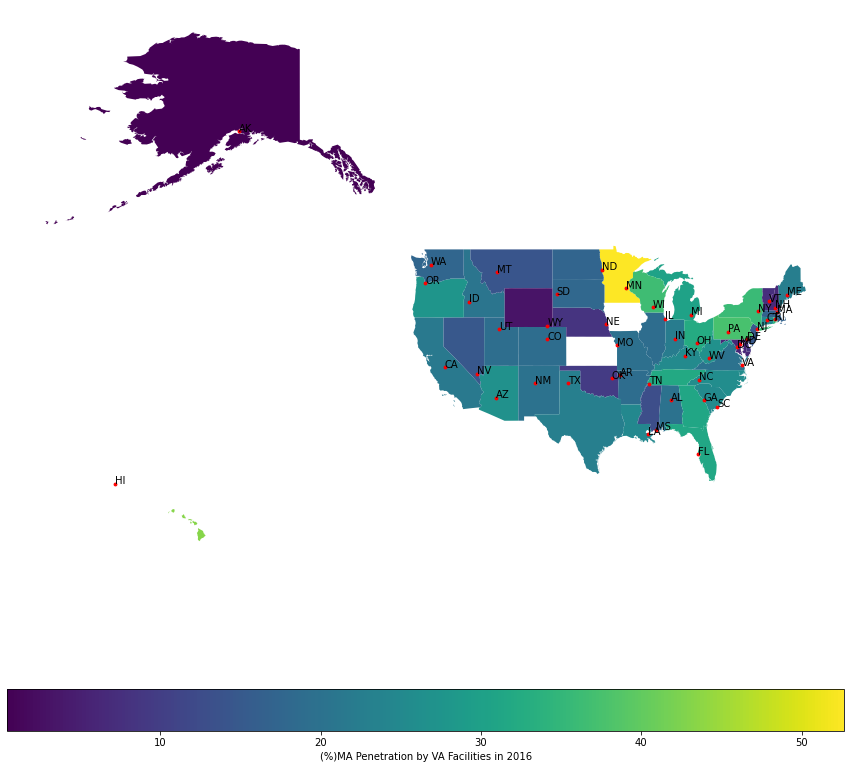

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15,15)) 
figure = geo.plot(column = 'mean', cmap = 'viridis',  ax = ax, legend = True, legend_kwds={'label': "(%)MA Penetration by VA Facilities in 2016",
                        'orientation': "horizontal"} )
ax.set_axis_off()

for xyz,dat in geo.iterrows():
    #print(dat.city, dat.lng, dat.lat)
    figure.scatter(dat.longitude, dat.latitude, s=8, color='red')
    figure.annotate(dat.StateAbbrev, (dat.longitude, dat.latitude))

6.	Now imagine you were working on a project that required computation of % penetration of Medicare Advantage by VA facility, rather than by state. In a few sentences, explain the process you would go through to aggregate county-level data to facility-level. What additional data might you need? 

**A: I am not sure that I totally understood the question. If we would like to study the computation of MA penetration at the county level where the VA facility is located, we would need to have enrollment data at county level. However, if we are looking for newly-enrolled individuals who go to VA facilities, we would need data from VA.**

7.	The demographic characteristics of the VA patient population is different from that of the general US population. Please calculate and prepare a table containing state-level percentages by age group, sex and race for the Veteran population. You can get the data on patient population at the VA from the following website: https://www.va.gov/vetdata/VeteranPopulation.asp  

**P.S.: this link is broken. The correct one is https://www.va.gov/vetdata/veteran_population.asp**

In [18]:
# The VA population excel file is not easy to import due to filter option 
# (female/male or race options). So I saved it seperately as csv then imported each file into the pandas. 
# Here I show the table for race and gender. 

pd.set_option("display.max_rows", None, "display.max_columns", None)

race_male = pd.read_csv("/Users/mehme/Downloads/8L_VP2018_Race_Ethnicity_State-Male.csv", skiprows=5, keep_default_na=False)
race_male = race_male.iloc[: , :-5]
race_male['Gender'] = "male"

race_female = pd.read_csv("/Users/mehme/Downloads/8L_VP2018_Race_Ethnicity_State-Female.csv",  skiprows=5, keep_default_na=False)
race_female = race_female.iloc[: , :-5]
race_female['Gender'] = "female"

race = pd.concat([race_male, race_female])
race[race.columns[1:11]]=race[race.columns[1:11]].replace(',','',regex=True).astype('int64')

## After Data Cleaning, it is time to calculate the percentages of gender and race categories by states.
table = race.groupby(['State', 'Gender']).mean()
a = table.values
table.iloc[:,1:] = (a[:,1:]/a[:,0,None]) * 100

gender = table.groupby(['State','Gender']).agg({'All Veterans': 'sum'})
gender = gender.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gender = gender.rename(columns={"All Veterans": "Gender Percent"}, errors="raise")
race = pd.concat([table, gender], axis=1)
race.round(2)

## There is one thing that I should note. The sum of percentages of race categories 
## does not make %100. Because each category is not mutually exclusive.

All Veterans  White, alone  \
State                  Gender                               
Alabama                female       41038.0         55.24   
                       male        332411.0         74.56   
Alaska                 female       10240.0         72.84   
                       male         62986.0         80.33   
Arizona                female       52733.0         80.03   
                       male        474145.0         87.95   
Arkansas               female       19300.0         76.57   
                       male        197038.0         83.83   
California             female      163302.0         67.66   
                       male       1589152.0         74.33   
Colorado               female       45413.0         81.54   
                       male        355416.0         87.21   
Connecticut            female       13895.0         82.56   
                       male        173762.0         88.10   
Delaware               female        7229.0         67.80   
                       male         66056.0         77.76   
District of Columbia   female        4367.0         51.09   
                       male         26035.0         42.01   
Florida                female      156954.0         71.88   
                       male       1412713.0         85.05   
Georgia                female       93237.0         45.20   
                       male        616382.0         65.05   
Grand Total            female     1998351.0         71.31   
                       male      18335543.0         82.22   
Hawaii                 female       12722.0         44.23   
                       male        105454.0         39.92   
Idaho                  female       11820.0         90.81   
                       male        116160.0         93.91   
Illinois               female       53236.0         76.82   
                       male        583530.0         83.08   
Indiana                female       35501.0         84.23   
                       male        393816.0         88.68   
Iowa                   female       15298.0         96.88   
                       male        193335.0         96.83   
Island Areas & Foreign female        5727.0         53.47   
                       male         88023.0         71.90   
Kansas                 female       19436.0         77.86   
                       male        185652.0         86.86   
Kentucky               female       26336.0         79.85   
                       male        270865.0         88.04   
Louisiana              female       33089.0         60.95   
                       male        264589.0         71.57   
Maine                  female        9755.0         94.93   
                       male        105545.0         97.39   
Maryland               female       54646.0         51.46   
                       male        344475.0         64.32   
Massachusetts          female       24855.0         84.48   
                       male        309389.0         91.88   
Michigan               female       46994.0         78.62   
                       male        550265.0         86.96   
Minnesota              female       25742.0         88.21   
                       male        305641.0         93.87   
Mississippi            female       21872.0         55.14   
                       male        168970.0         70.71   
Missouri               female       37252.0         77.43   
                       male        400434.0         87.77   
Montana                female        9011.0         89.24   
                       male         83234.0         91.57   
Nebraska               female       12243.0         88.74   
                       male        120338.0         92.41   
Nevada                 female       23726.0         65.22   
                       male        205232.0         77.62   
New Hampshire          female        8814.0         89.05   
                       male         94391.0         97.10   
New J

In [19]:
# Here I show the table for age group and gender. 

age_male = pd.read_csv("/Users/mehme/Downloads/6L_VetPop2018_State_male.csv", skiprows=5, keep_default_na=False)
age_male = age_male.iloc[: , :-7]
age_male = age_male.replace(r'^s*$', float('NaN'), regex = True)
age_male.dropna(inplace = True)
age_male['Gender'] = "male"

age_female = pd.read_csv("/Users/mehme/Downloads/6L_VetPop2018_State_female.csv", skiprows=5, keep_default_na=False)
age_female = age_female.iloc[: , :-7]
age_female = age_female.replace(r'^s*$', float('NaN'), regex = True)
age_female.dropna(inplace = True)
age_female['Gender'] = "female"

age = pd.concat([age_male, age_female])
age[age.columns[1:17]]=age[age.columns[1:17]].replace(',','',regex=True).astype('int64')

## After Data Cleaning, it is time to calculate the percentages of gender and age categories by states.
table = age.groupby(['State','Gender']).mean()
a = table.values
table.iloc[:,0:15] = (a[:,0:15]/a[:,15,None]) * 100

gender = table.groupby(['State','Gender']).agg({'Grand Total': 'sum'})
gender = gender.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gender = gender.rename(columns={"Grand Total": "Gender Percent"}, errors="raise")
age = pd.concat([table, gender], axis=1)
age.round(2)

< 20   20-24  25-29  30-34  35-39  40-44  \
State                  Gender                                             
Alabama                female   0.16   2.89   6.73   8.76  10.26   9.89   
                       male     0.04   1.22   2.97   4.23   4.78   4.88   
Alaska                 female   0.14   2.69   7.02  10.27  12.39  10.09   
                       male     0.05   1.88   5.69   7.17   7.62   6.59   
Arizona                female   0.15   2.23   5.72   7.74   9.34   8.26   
                       male     0.03   0.93   3.03   4.29   4.64   4.46   
Arkansas               female   0.12   3.72   7.07   9.14  10.26   9.10   
                       male     0.06   1.51   3.36   4.44   4.88   4.80   
California             female   0.14   2.91   7.81  10.05  11.08   8.85   
                       male     0.04   1.16   3.68   4.91   5.35   4.97   
Colorado               female   0.11   2.44   6.41   9.48  10.59   9.48   
                       male     0.04   1.13   3.86   5.49   5.58   5.32   
Connecticut            female   0.17   3.15   6.78   8.48  10.51   9.86   
                       male     0.05   1.13   2.55   3.60   3.94   3.93   
Delaware               female   0.11   2.56   5.09   7.36   9.78   9.16   
                       male     0.03   0.84   2.36   3.25   3.71   3.70   
District of Columbia   female   0.00   1.17   3.71   8.40  12.04   9.62   
                       male     0.00   0.85   2.47   4.97   6.79   5.87   
Florida                female   0.15   2.25   5.45   7.74   9.42   9.06   
                       male     0.03   0.80   2.33   3.43   3.97   4.12   
Georgia                female   0.18   3.08   7.54   9.54  10.98  10.26   
                       male     0.04   1.39   3.61   4.78   5.17   5.36   
Grand Total            female   0.14   2.75   6.50   8.96  10.54   9.45   
                       male     0.04   1.13   3.06   4.30   4.81   4.73   
Hawaii                 female   0.00   3.15   9.52  12.40  14.86  11.73   
                       male     0.01   1.21   3.90   5.13   6.18   5.61   
Idaho                  female   0.11   2.68   5.72   8.70   9.38   7.92   
                       male     0.06   1.04   3.06   4.16   4.66   4.67   
Illinois               female   0.19   3.41   6.21   8.73  11.20   9.63   
                       male     0.04   1.19   2.74   3.94   4.68   4.49   
Indiana                female   0.19   3.05   6.44   8.15   8.80   7.85   
                       male     0.03   1.23   3.00   4.13   4.28   4.15   
Iowa                   female   0.15   3.12   6.55   9.15  10.43   8.87   
                       male     0.03   1.26   2.83   3.97   4.20   4.15   
Island Areas & Foreign female   0.02   1.96   7.54   8.68  10.48  10.16   
                       male     0.00   0.35   1.78   3.21   4.39   5.09   
Kansas                 female   0.13   3.71   8.23  10.96  11.43   9.65   
                       male     0.03   1.46   4.34   5.46   5.54   5.26   
Kentucky               female   0.18   2.76   5.41   8.22   9.64   8.84   
                       male     0.04   1.36   3.12   4.32   4.68   4.91   
Louisiana              female   0.16   3.65   7.22   9.88  13.17  10.91   
                       male     0.05   1.51   3.45   4.75   6.16   5.92   
Maine                  female   0.07   1.96   4.52   6.59   7.51   8.74   
                       male     0.05   0.90   2.31   3.33   3.53   4.15   
Maryland               female   0.07   1.77   4.44   7.29  10.78  10.30   
                       male     0.03   0.93   2.57   3.99   5.13   5.32   
Massachusetts          female   0.08   2.43   5.52   7.68   9.18   8.56   
                       male     0.03   0.91   2.48   3.64   3.83   3.74   
Michigan               female   0.17   2.51   5.27   7.33   8.20   8.17   
                       male     0.03   0.92   2.42   3.45   3.57   3.62   
Minnesota              female   0.10   3.38   6.06   8.98   9.70   7.88   
                       male     0.04   1.17   2.64   3.7